In [ ]:
from HelpFunctions.date_and_time import most_recent_thursday, split_time
from DAX.HelpFunctions.get_dax_data import get_dax_data
from datetime import timedelta
from HelpFunctions.calc_score import evaluate_horizon
from HelpFunctions.mix_models import mix_models
import pandas as pd
from DAX.Models.baseline import baseline
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
# import importlib
# importlib.reload(Energy.Models)

In [ ]:
df = get_dax_data()

In [ ]:
# We have to start with the tuesday data
start_date_excl = most_recent_thursday(df) - timedelta(days=1)
df_cval = df.loc[df.index < start_date_excl]
df_cval.index = df_cval.index.date

In [60]:
def evaluate_models(models, df, last_x, years =False, months=False, weeks=False):
    # Check that exactly one of the boolean parameters is True
    if sum([years, months, weeks]) != 1:
        raise ValueError("Exactly one of the boolean parameters (years, months, weeks) must be True.")
    
    years = int(years)
    months = int(months)
    weeks = int(weeks)
        
    for m in models:
        print(f'*********** Start the evaluation of Model {m["name"]} ***********')
        m['evaluation'] = evaluate_model(m, df, last_x, years, months, weeks)
        
def evaluate_model(model, df, last_x, years, months, weeks):
    df_before = df
    evaluation = pd.DataFrame()
    
    for w in range(last_x):
        print(f'Iteration {w+1} of {last_x}')
        df_before, df_after = split_time(df_before, num_years=years, num_months=months, num_weeks=weeks)
        
        pred = None
        # Is mixed model?
        if callable(model['function']):
            pred = model['function'](df_before)
        else: 
            pred = mix_models(model['function'][0], model['function'][1], df_before, target='DAX')
        # Makes sure we try to find observations for dates that have an observation (e.g. 05-01 is missing)
        dates = [[horizon+1, d] for horizon,d in enumerate(pred['forecast_date']) if d in df.index]
        pred = pred.set_index('forecast_date')

        
        # Add observations to pred
        pred['observation'] = ''
        pred['score'] = ''
        for h,d in dates:
            # Look up the right observation for date d
            o = df.loc[d][f'ret{h}']
            pred.loc[d,'observation'] = o
    
        # Add scores to pred
        for index, row in pred.iterrows():
            quantile_preds = row[['q0.025','q0.25','q0.5','q0.75','q0.975']]
            observation = row['observation']
            
            score = evaluate_horizon(quantile_preds, observation)
            
            pred.at[index, 'score'] = score
            
        evaluation = pd.concat([evaluation, pred])
    evaluation = evaluation.sort_index()
    
    return evaluation

In [103]:
from DAX.Models import arma_garch_11 as ag
from DAX.Models import quant_reg as qr
from DAX.Models import baseline as bl
import importlib
importlib.reload(qr)
importlib.reload(bl)

models = [
    {
        'name': 'quant_reg_1_day',
        'function': qr.quant_reg_1d
    },
    {
        'name': 'quant_reg_3_day',
        'function': qr.quant_reg_3d
    },
    {
        'name': 'quant_reg_5_day',
        'function': qr.quant_reg_5d
    },
    {
        'name': 'quant_reg_10_day',
        'function': qr.quant_reg_10d
    },
    {
        'name': 'baseline',
        'function': bl.baseline
    },
    # {
    #     'name': 'garch11_norm_1y',
    #     'function': ag.garch11_norm_1y
    # },
    # {
    #     'name': 'garch11_norm_2y',
    #     'function': ag.garch11_norm_2y
    # },
    # {
    #     'name': 'garch11_norm_5y',
    #     'function': ag.garch11_norm_5y
    # },
]


In [104]:
evaluate_models(models, df, 30, weeks=True)

*********** Start the evaluation of Model quant_reg_1_day ***********
Iteration 1 of 30
  forecast_date target horizon    q0.025     q0.25      q0.5     q0.75  \
0    2024-02-02    DAX   1 day -0.264911 -0.264911  0.264908  0.264911   
0    2024-02-05    DAX   2 day -2.223498 -0.364181  0.144660  0.654243   
0    2024-02-06    DAX   5 day -3.510884 -0.424191  0.276878  0.954118   
0    2024-02-07    DAX   6 day -3.675713 -0.361736  0.354276  1.278179   
0    2024-02-08    DAX   7 day -3.858972 -0.360625  0.569498  1.509558   

     q0.975  
0  0.264911  
0  2.355308  
0  3.118285  
0  3.953856  
0  4.776779  
Iteration 2 of 30
  forecast_date target horizon    q0.025     q0.25      q0.5     q0.75  \
0    2024-01-26    DAX   1 day -0.100601 -0.100601  0.100600  0.100601   
0    2024-01-29    DAX   2 day -2.118430 -0.198410  0.206157  0.529865   
0    2024-01-30    DAX   5 day -3.513744 -0.235542  0.326132  0.848148   
0    2024-01-31    DAX   6 day -3.466452 -0.173053  0.422971  1.21860

/Users/elias/Desktop/PTSFC/venv/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


  forecast_date target horizon    q0.025     q0.25      q0.5     q0.75  \
0    2023-11-10    DAX   1 day -0.804006 -0.804005  0.803982  0.804005   
0    2023-11-13    DAX   2 day -2.943397 -0.936014 -0.048464  1.077340   
0    2023-11-14    DAX   5 day -4.439303 -1.063659  0.088618  1.281808   
0    2023-11-15    DAX   6 day -4.903740 -1.048930  0.079870  1.444532   
0    2023-11-16    DAX   7 day -5.627386 -1.112185  0.188827  1.560819   

     q0.975  
0  0.804006  
0  2.876557  
0  3.976896  
0  4.865035  
0  5.467537  
Iteration 14 of 30
  forecast_date target horizon    q0.025     q0.25      q0.5     q0.75  \
0    2023-11-03    DAX   1 day -1.465627 -1.465626  1.465575  1.465626   
0    2023-11-06    DAX   2 day -3.719354 -1.609517 -0.307864  1.573784   
0    2023-11-07    DAX   5 day -5.307289 -1.810682 -0.142190  1.698404   
0    2023-11-08    DAX   6 day -6.110220 -1.838800 -0.283775  1.640753   
0    2023-11-09    DAX   7 day -7.602848 -2.023140 -0.328784  1.640712   

     q0

/Users/elias/Desktop/PTSFC/venv/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


  forecast_date target horizon    q0.025     q0.25      q0.5     q0.75  \
0    2023-09-29    DAX   1 day -0.694479 -0.694479  0.694461  0.694479   
0    2023-10-02    DAX   2 day -2.814942 -0.814586  0.026355  0.983722   
0    2023-10-03    DAX   5 day -4.295612 -0.904346  0.117001  1.209498   
0    2023-10-04    DAX   6 day -4.704013 -0.872718  0.150524  1.400868   
0    2023-10-05    DAX   7 day -5.300361 -0.926028  0.272752  1.529523   

     q0.975  
0  0.694479  
0  2.770656  
0  3.804360  
0  4.679913  
0  5.327197  
Iteration 20 of 30
  forecast_date target horizon    q0.025     q0.25      q0.5     q0.75  \
0    2023-09-22    DAX   1 day -1.337860 -1.337860  1.337831  1.337860   
0    2023-09-25    DAX   2 day -3.569507 -1.462201 -0.175203  1.477922   
0    2023-09-26    DAX   5 day -5.139668 -1.623067 -0.084598  1.616328   
0    2023-09-27    DAX   6 day -5.877231 -1.640734 -0.188767  1.606536   
0    2023-09-28    DAX   7 day -7.221364 -1.776687 -0.159555  1.636502   

     q0

/Users/elias/Desktop/PTSFC/venv/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


  forecast_date target horizon    q0.025     q0.25      q0.5     q0.75  \
0    2024-02-02    DAX   1 day -0.643143 -0.243784  0.014544  0.291876   
0    2024-02-05    DAX   2 day -0.822416 -0.331281  0.104603  0.492386   
0    2024-02-06    DAX   5 day -0.850426 -0.289642  0.261172  0.642076   
0    2024-02-07    DAX   6 day -1.405250 -0.142834  0.327553  0.853956   
0    2024-02-08    DAX   7 day -1.656726 -0.099009  0.553159  1.220577   

     q0.975  
0  0.651419  
0  0.810550  
0  0.850426  
0  2.204211  
0  2.861050  
Iteration 2 of 30
  forecast_date target horizon    q0.025     q0.25      q0.5     q0.75  \
0    2024-01-26    DAX   1 day -1.584941 -0.572066  0.100602  0.645573   
0    2024-01-29    DAX   2 day -1.888440 -0.857705  0.070142  1.023056   
0    2024-01-30    DAX   5 day -2.006821 -1.061663  0.123186  1.330636   
0    2024-01-31    DAX   6 day -2.926851 -1.006401  0.153439  1.432235   
0    2024-02-01    DAX   7 day -3.581085 -1.040021  0.289376  1.622449   

     q0.

/Users/elias/Desktop/PTSFC/venv/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


  forecast_date target horizon    q0.025     q0.25      q0.5     q0.75  \
0    2023-08-25    DAX   1 day -1.125024 -0.415116  0.059953  0.491275   
0    2023-08-28    DAX   2 day -1.399082 -0.599675  0.101170  0.794450   
0    2023-08-29    DAX   5 day -1.480857 -0.661188  0.195894  1.026561   
0    2023-08-30    DAX   6 day -2.060192 -0.584492  0.295707  1.191808   
0    2023-08-31    DAX   7 day -2.653040 -0.499912  0.432489  1.433856   

     q0.975  
0  1.090417  
0  1.363637  
0  1.480857  
0  2.843605  
0  3.602865  
Iteration 25 of 30
  forecast_date target horizon    q0.025     q0.25      q0.5     q0.75  \
0    2023-08-18    DAX   1 day -1.314420 -0.484181  0.075658  0.562646   
0    2023-08-21    DAX   2 day -1.621556 -0.712299  0.091138  0.901391   
0    2023-08-22    DAX   5 day -1.720822 -0.826802  0.168184  1.163883   
0    2023-08-23    DAX   6 day -2.380720 -0.768626  0.251096  1.301755   
0    2023-08-24    DAX   7 day -3.071232 -0.678613  0.395359  1.507651   

     q0

/Users/elias/Desktop/PTSFC/venv/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


  forecast_date target horizon    q0.025     q0.25      q0.5     q0.75  \
0    2023-08-18    DAX   1 day -1.649925 -0.481730  0.079038  0.592763   
0    2023-08-21    DAX   2 day -2.075420 -0.673317  0.091217  0.926458   
0    2023-08-22    DAX   5 day -2.377919 -0.806004  0.170937  1.151286   
0    2023-08-23    DAX   6 day -2.610702 -0.850059  0.233253  1.377076   
0    2023-08-24    DAX   7 day -2.918087 -0.847695  0.360277  1.547423   

     q0.975  
0  1.580831  
0  2.160514  
0  2.449789  
0  2.775380  
0  3.086983  
Iteration 26 of 30
  forecast_date target horizon    q0.025     q0.25      q0.5     q0.75  \
0    2023-08-11    DAX   1 day -1.464846 -0.409057  0.076802  0.565840   
0    2023-08-14    DAX   2 day -1.823193 -0.580961  0.116991  0.857243   
0    2023-08-15    DAX   5 day -2.093639 -0.677489  0.195619  1.081298   
0    2023-08-16    DAX   6 day -2.297664 -0.691334  0.269697  1.279243   
0    2023-08-17    DAX   7 day -2.573703 -0.654538  0.404678  1.449729   

     q0

/Users/elias/Desktop/PTSFC/venv/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


  forecast_date target horizon    q0.025     q0.25      q0.5     q0.75  \
0    2023-12-22    DAX   1 day -0.993834 -0.118585  0.026164  0.283415   
0    2023-12-25    DAX   2 day -1.208207 -0.276332  0.111472  0.370116   
0    2023-12-26    DAX   5 day -1.106561 -0.244311  0.199923  0.409685   
0    2023-12-27    DAX   6 day -0.971317 -0.160037  0.179185  0.523774   
0    2023-12-28    DAX   7 day -0.578269 -0.158740  0.333115  0.875309   

     q0.975  
0  0.693519  
0  1.223479  
0  1.298569  
0  1.555456  
0  1.809705  
Iteration 8 of 30
  forecast_date target horizon    q0.025     q0.25      q0.5     q0.75  \
0    2023-12-15    DAX   1 day -1.356695 -0.244138  0.041360  0.388258   
0    2023-12-18    DAX   2 day -1.711244 -0.419998  0.114175  0.552918   
0    2023-12-19    DAX   5 day -1.837356 -0.442821  0.201202  0.681868   
0    2023-12-20    DAX   6 day -1.808778 -0.357083  0.208308  0.815689   
0    2023-12-21    DAX   7 day -1.635571 -0.330514  0.368053  1.127131   

     q0.

/Users/elias/Desktop/PTSFC/venv/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


  forecast_date target horizon    q0.025     q0.25      q0.5     q0.75  \
0    2023-10-27    DAX   1 day -1.991761 -0.513168  0.041061  0.588164   
0    2023-10-30    DAX   2 day -2.758661 -0.714380  0.065521  0.898090   
0    2023-10-31    DAX   5 day -3.234770 -0.862749  0.143279  1.059343   
0    2023-11-01    DAX   6 day -3.526610 -0.849396  0.182584  1.248186   
0    2023-11-02    DAX   7 day -3.596143 -0.945749  0.313810  1.473135   

     q0.975  
0  1.655083  
0  2.159731  
0  2.744057  
0  3.003766  
0  3.359441  
Iteration 16 of 30
  forecast_date target horizon    q0.025     q0.25      q0.5     q0.75  \
0    2023-10-20    DAX   1 day -2.180787 -0.570439  0.049982  0.647169   
0    2023-10-23    DAX   2 day -3.050657 -0.796495  0.046714  1.002003   
0    2023-10-24    DAX   5 day -3.677637 -0.974753  0.135391  1.189634   
0    2023-10-25    DAX   6 day -3.952089 -0.976503  0.184047  1.388050   
0    2023-10-26    DAX   7 day -4.349517 -1.088606  0.311002  1.596327   

     q0

/Users/elias/Desktop/PTSFC/venv/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
/Users/elias/Desktop/PTSFC/venv/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
/Users/elias/Desktop/PTSFC/venv/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


  forecast_date target horizon    q0.025     q0.25      q0.5     q0.75  \
0    2023-10-13    DAX   1 day -2.012616 -0.514927  0.040250  0.594805   
0    2023-10-16    DAX   2 day -2.789193 -0.706324  0.079400  0.911766   
0    2023-10-17    DAX   5 day -3.278267 -0.869075  0.140063  1.087968   
0    2023-10-18    DAX   6 day -3.579356 -0.850721  0.184578  1.265419   
0    2023-10-19    DAX   7 day -3.711396 -0.944944  0.314165  1.493267   

     q0.975  
0  1.625719  
0  2.168720  
0  2.707521  
0  3.034063  
0  3.431303  
Iteration 18 of 30
  forecast_date target horizon    q0.025     q0.25      q0.5     q0.75  \
0    2023-10-06    DAX   1 day -1.728394 -0.411859  0.036491  0.510383   
0    2023-10-09    DAX   2 day -2.338265 -0.591750  0.080664  0.756652   
0    2023-10-10    DAX   5 day -2.668382 -0.679018  0.151876  0.893397   
0    2023-10-11    DAX   6 day -2.813332 -0.651804  0.188387  1.058743   
0    2023-10-12    DAX   7 day -2.760240 -0.706653  0.325572  1.297347   

     q0

/Users/elias/Desktop/PTSFC/venv/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


  forecast_date target horizon    q0.025     q0.25      q0.5     q0.75  \
0    2023-09-15    DAX   1 day -1.268009 -0.247589  0.030054  0.381114   
0    2023-09-18    DAX   2 day -1.626081 -0.386419  0.123952  0.520177   
0    2023-09-19    DAX   5 day -1.697734 -0.343104  0.186773  0.645697   
0    2023-09-20    DAX   6 day -1.667834 -0.284764  0.217758  0.783496   
0    2023-09-21    DAX   7 day -1.373512 -0.241924  0.376827  1.061551   

     q0.975  
0  1.030645  
0  1.497767  
0  1.805865  
0  2.138404  
0  2.408873  
Iteration 22 of 30
  forecast_date target horizon    q0.025     q0.25      q0.5     q0.75  \
0    2023-09-08    DAX   1 day -1.361205 -0.242884  0.031470  0.382468   
0    2023-09-11    DAX   2 day -1.678532 -0.399558  0.110209  0.534847   
0    2023-09-12    DAX   5 day -1.795690 -0.389271  0.200507  0.666423   
0    2023-09-13    DAX   6 day -1.883493 -0.308991  0.215946  0.764090   
0    2023-09-14    DAX   7 day -1.522978 -0.287393  0.372956  1.056209   

     q0

/Users/elias/Desktop/PTSFC/venv/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


  forecast_date target horizon    q0.025     q0.25      q0.5     q0.75  \
0    2023-07-21    DAX   1 day -1.651200 -0.361819  0.058570  0.505121   
0    2023-07-24    DAX   2 day -2.214363 -0.533442  0.128283  0.747011   
0    2023-07-25    DAX   5 day -2.504354 -0.534281  0.217633  0.904736   
0    2023-07-26    DAX   6 day -2.628318 -0.528175  0.230369  1.071699   
0    2023-07-27    DAX   7 day -2.540200 -0.542071  0.382678  1.328132   

     q0.975  
0  1.367339  
0  1.796114  
0  2.248706  
0  2.509804  
0  2.831455  
Iteration 30 of 30
  forecast_date target horizon    q0.025     q0.25      q0.5     q0.75  \
0    2023-07-14    DAX   1 day -2.597197 -0.669096  0.111076  0.782701   
0    2023-07-17    DAX   2 day -3.663395 -0.910468  0.115908  1.234899   
0    2023-07-18    DAX   5 day -4.455963 -1.092836  0.173999  1.532001   
0    2023-07-19    DAX   6 day -4.933123 -1.161657  0.272123  1.770171   
0    2023-07-20    DAX   7 day -5.355452 -1.307770  0.398675  1.968631   

     q0

In [105]:
# with open('./Model evaluations/ARMAGARCH11.pkl', 'wb') as f:
#     pickle.dump(models, f)
#         
# with open('./Model evaluations/baseline.pkl', 'rb') as f:
#     models = pickle.load(f)

In [106]:
horizons = [str(i) + " day" for i in (1, 2, 5, 6, 7)]
scores = []
names = []
for h in horizons:
    for m in models:
        col_name = f'{m["name"]}: {h}'
        scores.append(m['evaluation']['score'][m['evaluation']['horizon'] == h])
        names.append(col_name)

score_df = pd.concat(scores, axis=1,keys=names)
score_df = score_df.sort_index()

In [107]:
# score_df

# Plot obtained scores

*** Means ***


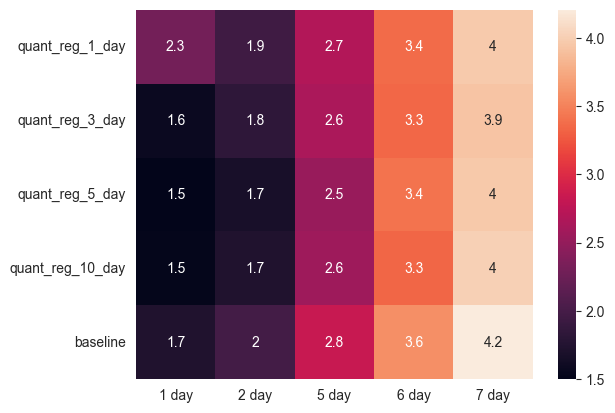

                     1 day     2 day     5 day     6 day     7 day
quant_reg_1_day   2.293399  1.947886  2.691392  3.371110  3.967476
quant_reg_3_day   1.573522  1.825808  2.646452  3.345027  3.924169
quant_reg_5_day   1.497400  1.670634  2.524899  3.410265  3.958791
quant_reg_10_day  1.527557  1.722764  2.556702  3.334209  4.010519
baseline          1.726224  1.981822  2.831011  3.576804  4.207527
*** Stds ***


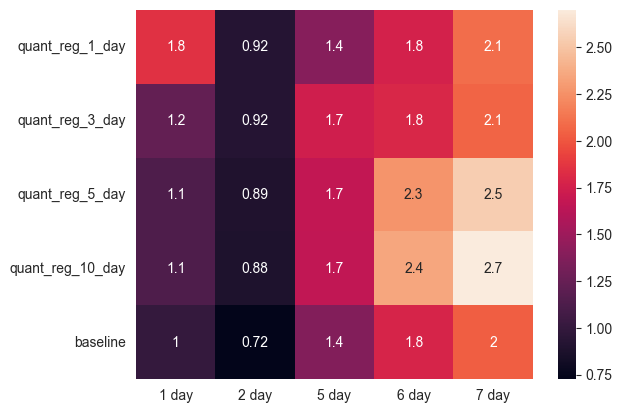

                     1 day     2 day     5 day     6 day     7 day
quant_reg_1_day   1.847934  0.917923  1.394461  1.767058  2.098872
quant_reg_3_day   1.228505  0.924095  1.738180  1.791342  2.056528
quant_reg_5_day   1.127440  0.887265  1.669022  2.263892  2.542959
quant_reg_10_day  1.127227  0.880516  1.659471  2.350284  2.702229
baseline          0.995858  0.724538  1.375364  1.780410  2.033507


In [109]:
def print_means_stds(score_df, models_display):
    means = pd.DataFrame(columns=[str(i) + " day" for i in (1, 2, 5, 6, 7)])
    stds = pd.DataFrame(columns=[str(i) + " day" for i in (1, 2, 5, 6, 7)])
    for h in [str(i) + " day" for i in (1, 2, 5, 6, 7)]:
        m = score_df.loc[:,[f'{m}: {h}' for m in models_display]].mean()
        m.index = [m['name'] for m in models]
        means.loc[:,h] = m
        s = score_df.loc[:,[f'{m}: {h}' for m in models_display]].std()
        s.index = [m['name'] for m in models]
        stds.loc[:,h] = s
    print('*** Means ***')
    means = means.astype(float)
    stds = stds.astype(float)
    sns.heatmap(means, annot=True)
    plt.show()
    
    
    
    print(means)
    print('*** Stds ***')
    sns.heatmap(stds, annot=True)
    plt.show()
    print(stds)
    
    
print_means_stds(score_df, [m['name'] for m in models])

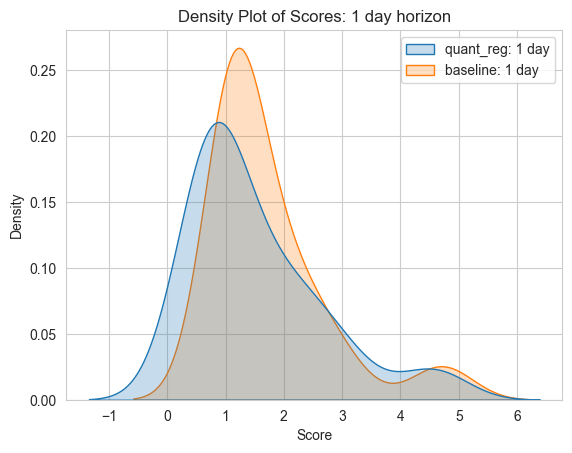

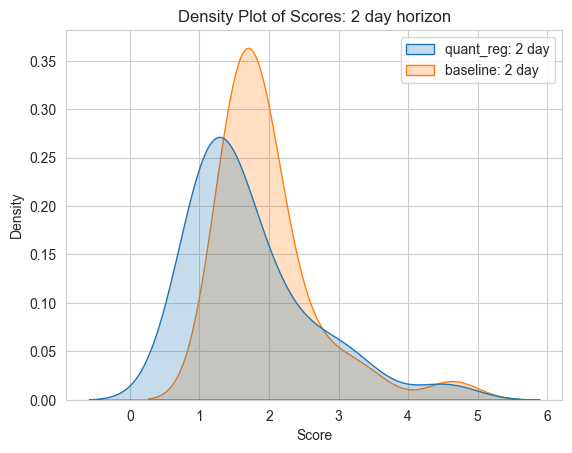

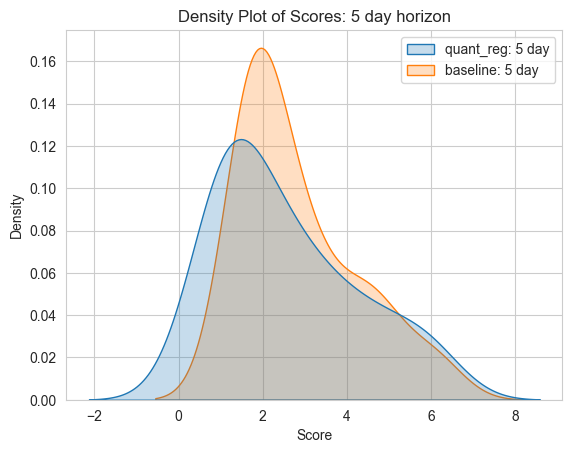

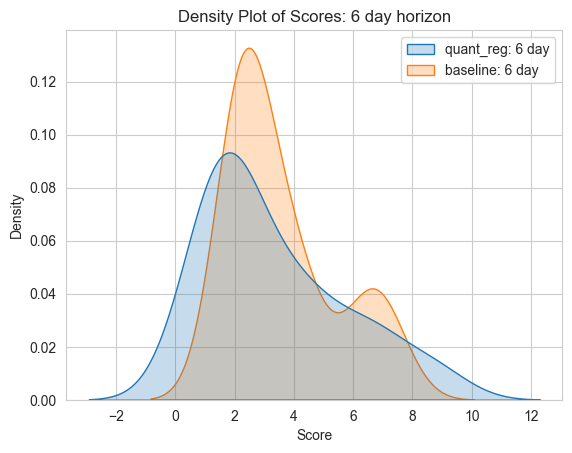

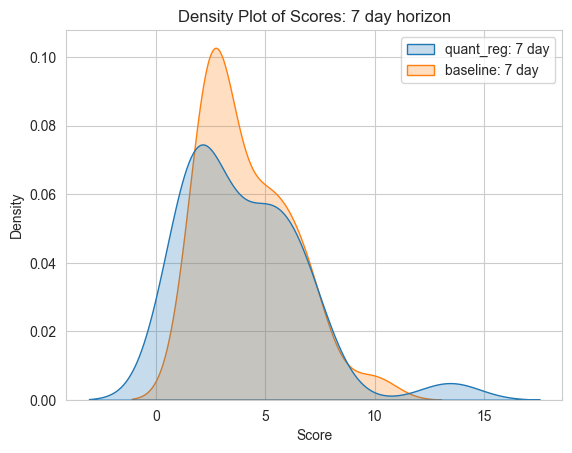

In [82]:
models_display = [m['name'] for m in models]
for h in [str(i) + " day" for i in (1, 2, 5, 6, 7)]:
    sns.kdeplot(data=score_df.loc[:,[f'{m}: {h}' for m in models_display]], fill=True)
    
    # Adding labels and title
    plt.xlabel('Score')
    plt.ylabel('Density')
    plt.title(f'Density Plot of Scores: {h} horizon')

    # Display the plot
    plt.savefig(f'../Plots/density_plot_{h.replace(" ", "_")}.png')
    plt.show()

In [71]:
import statistics
horizon = '1 day'
score_df.loc[:,[f'{m}: {h}' for m in models_display]]
for i,m in enumerate([statistics.mean(score_df.loc[:,f'{m}: {horizon}'].dropna()) for m in models_display]):
    print(f'{models_display[i]} mean score in the past 50 weeks: {m}')

quant_reg mean score in the past 50 weeks: 1.5275565210882445
baseline mean score in the past 50 weeks: 1.7262239319166002


In [ ]:
for h in [str(i) + " day" for i in (1, 2, 5, 6, 7)]:
    score_df_36_no_na = score_df[score_df[f'{models_display[0]}: {h}'].notna()]
    for c in [f'{m}: {h}' for m in models_display]:
        plt.plot(score_df_36_no_na.index, score_df_36_no_na[c], label=c)

    plt.xlabel('time')
    plt.ylabel('score')
    plt.title(f'Comparison of scores over time: {h}')
    # plt.ylim(0,50)
    
    # Display legend
    plt.legend()
    plt.xticks(rotation=45)
    plt.savefig(f'../Plots/line_plot_{h.replace(" ", "_")}.png')

    # Show the plot
    plt.show()

In [ ]:


import matplotlib.pyplot as plt

def plot_evaluation(evaluation_data):
    # Assuming your DataFrame is named df
    numeric_columns = evaluation_data.select_dtypes(include='number')
    
    # Plotting
    plt.figure(figsize=(12, 8))
    for column in numeric_columns.columns:
        plt.plot(evaluation_data.index, evaluation_data[column], label=column)
    plt.plot(evaluation_data.index, evaluation_data['observation'], label = 'observation')
    
    # Adding labels and legend
    plt.xlabel('Forecast Date')
    plt.ylabel('Values')
    plt.title('Visualization of forecast and observation')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.savefig(f'../plots/evaluation_overview.png')
    plt.show()



In [ ]:
model_index = 1
plot_evaluation(models[model_index]['evaluation'][models[model_index]['evaluation']['horizon'] == '5 day'].dropna())

In [ ]:
models[0]['evaluation']